In [1]:
import datetime
import os
import numpy as np 
import pandas as pd
import glob

from qerr_utils import *
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Get a list of files in a directory
def getFiles(dirName):
    # os.chdir()
    allFiles = np.asarray(glob.glob(f"{dirName}/*.txt"))
    # Sort files - Note that this will not work if you have a different enumeration setup (e.g. you don't have an underscore)
    allFiles = sorted(allFiles, key = lambda x: float(x[x.rindex('_') + 1:x.index('.')]))
    return allFiles[:]

# Read data from data files
def getData(aFile):
    times = []
    deltas = []
    with open(aFile, 'r') as f:
        f.readline()
        for aLine in f:
            holder = aLine.split('\t')
            aDate = datetime.datetime.strptime(holder[0], '%m/%d/%Y %H:%M:%S.%f:')
            if float(holder[1].strip()) < 1e5:
                times.append(aDate)
                deltas.append(float(holder[1].strip()))
    return times, deltas

def scope_to_df(dataDir):
    allFiles = getFiles(dataDir)

    allTimes = []
    allDeltas = []
    
    # Get a list of files
    for aFile in allFiles:
        holderTimes, holderDeltas = getData(aFile)
        allTimes = np.concatenate((allTimes, holderTimes))
        allDeltas = np.concatenate((allDeltas, holderDeltas))
    
    df = pd.DataFrame(
        {
            'unix_timestamp': allTimes,
            'delta (ns)': allDeltas
        }
    )
    return df


def qerr_vs_time(df, scope_name):
    df['seconds elapsed'] = (df['towMS (ms)'] - df['towMS (ms)'].min()) / 10**3
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    sns.lineplot(df, x='seconds elapsed', y='qErr (ps)', linewidth=1.2, ax=ax)
    sns.regplot(df, x='seconds elapsed', y='qErr (ps)', scatter=True, ax=ax, order=15, scatter_kws={'s':2})
    
    ax.set_title(f'Q-Errors (ps) vs Elapsed Time (s) [{scope_name}]');
    ax.set_xlabel('Elapsed Time (s)')
    ax.set_ylabel('Q-Errors (ps)')

def qerr_hist(df):
    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.histplot(df, x='qErr (ps)', stat='density', ax=ax)
    ax.set_title('Distribution of Q-Errors (ps)')
    ax.set_xlabel('Q-Errors (ps)');

def load_merged_df(merged_fpath):
    df = load_data(merged_fpath)
    df['unix_timestamp'] = df['pkt_unix_timestamp_TIM-TP'].astype('datetime64[ns]')
    df['qErr (ns)'] = df['qErr (ps)'] * 1e-3
    return df

In [3]:
fpath_s3 = '/Users/nico/panoseti/gnss-pdft/qerr/data/start_2024-06-28T13:32:07.396892.device_ttyS3/data-type_MERGED.start_2024-06-28T13:32:07.396892'
fpath_s5 = '/Users/nico/panoseti/gnss-pdft/qerr/data/start_2024-06-28T13:32:32.459060.device_ttyS5/data-type_MERGED.start_2024-06-28T13:32:32.459060'

s3 = load_merged_df(fpath_s3)
s5 = load_merged_df(fpath_s5)
d = scope_to_df('/Users/nico/panoseti/gnss-pdft/scope/ScopeData/survey-in-end-20240628')
# qerr_vs_time(s3, 's3'),qerr_vs_time(s5, 's5');

In [72]:
# Get timestamps
s3_tst = s3['unix_timestamp']
s5_tst = s5['unix_timestamp']
d_tst = d['unix_timestamp']

# Find latest start time among d, s3, and s5 dataframes.
d_aligned_idx = np.searchsorted(d_tst, min(s3_tst))
d_aligned_idx = max(d_aligned_idx, np.searchsorted(d_tst, min(s5_tst)))
latest_start_time = d_tst[d_aligned_idx]

# Find indices in s3 and s5 closest to latest start time.
s3_start_idx = np.searchsorted(s3_tst, latest_start_time)
s5_start_idx = np.searchsorted(s5_tst, latest_start_time)

d_offset = 1

print(s3['unix_timestamp'].iloc[s3_start_idx])
print(s5['unix_timestamp'].iloc[s5_start_idx])
print(d['unix_timestamp'].iloc[d_aligned_idx + d_offset])

# Trim data frames so that the earliest record is the latest starting time.
s3_aligned = s3[s3_start_idx:]
s5_aligned = s5[s5_start_idx:]
d_aligned = d[d_aligned_idx + d_offset:]

# Trim data frames to same length.
len_limit = min(len(d_aligned), len(s3_aligned), len(s5_aligned))
s3_aligned = s3_aligned[:len_limit].reset_index(drop=True)
s5_aligned = s5_aligned[:len_limit].reset_index(drop=True)
d_aligned = d_aligned[:len_limit].reset_index(drop=True)

# Add elapsed time to dataframes for plotting
s3_aligned['Elapsed Time (s)'] = (s3_aligned['unix_timestamp'] - s3_aligned['unix_timestamp'].min()).apply(datetime.timedelta.total_seconds)
s5_aligned['Elapsed Time (s)'] = (s5_aligned['unix_timestamp'] - s5_aligned['unix_timestamp'].min()).apply(datetime.timedelta.total_seconds)
d_aligned['Elapsed Time (s)'] = (d_aligned['unix_timestamp'] - d_aligned['unix_timestamp'].min()).apply(datetime.timedelta.total_seconds)

print('\nAfter dataframe manipulations:')
print(s3_aligned.iloc[0, 0])
print(s5_aligned.iloc[0, 0])
print(d_aligned.iloc[0, 0])

"""
Dan's email:
corrected_deltaT =   (Tpps1 - qErr1) - (Tpps0 - qErr0)   (1) 
                 =   (Tpps1 - Tpps0) - (qErr1 - qErr0)   (2) 
                 =   deltaT - (qErr1 - qErr0)            (3)
"""


d_aligned['delta & qerrs (ns) [s3 - s5]'] = d_aligned['delta (ns)'] - (s3_aligned['qErr (ns)'] - s5_aligned['qErr (ns)'])
d_aligned['delta & qerrs (ns) [s5 - s3]'] = d_aligned['delta (ns)'] - (s5_aligned['qErr (ns)'] - s3_aligned['qErr (ns)'])

2024-06-28 13:32:34.359186
2024-06-28 13:32:34.361470
2024-06-28 13:32:34.514167

After dataframe manipulations:
2024-06-28 13:32:34.359186
2024-06-28 13:32:34.361470
2024-06-28 13:32:34.514167


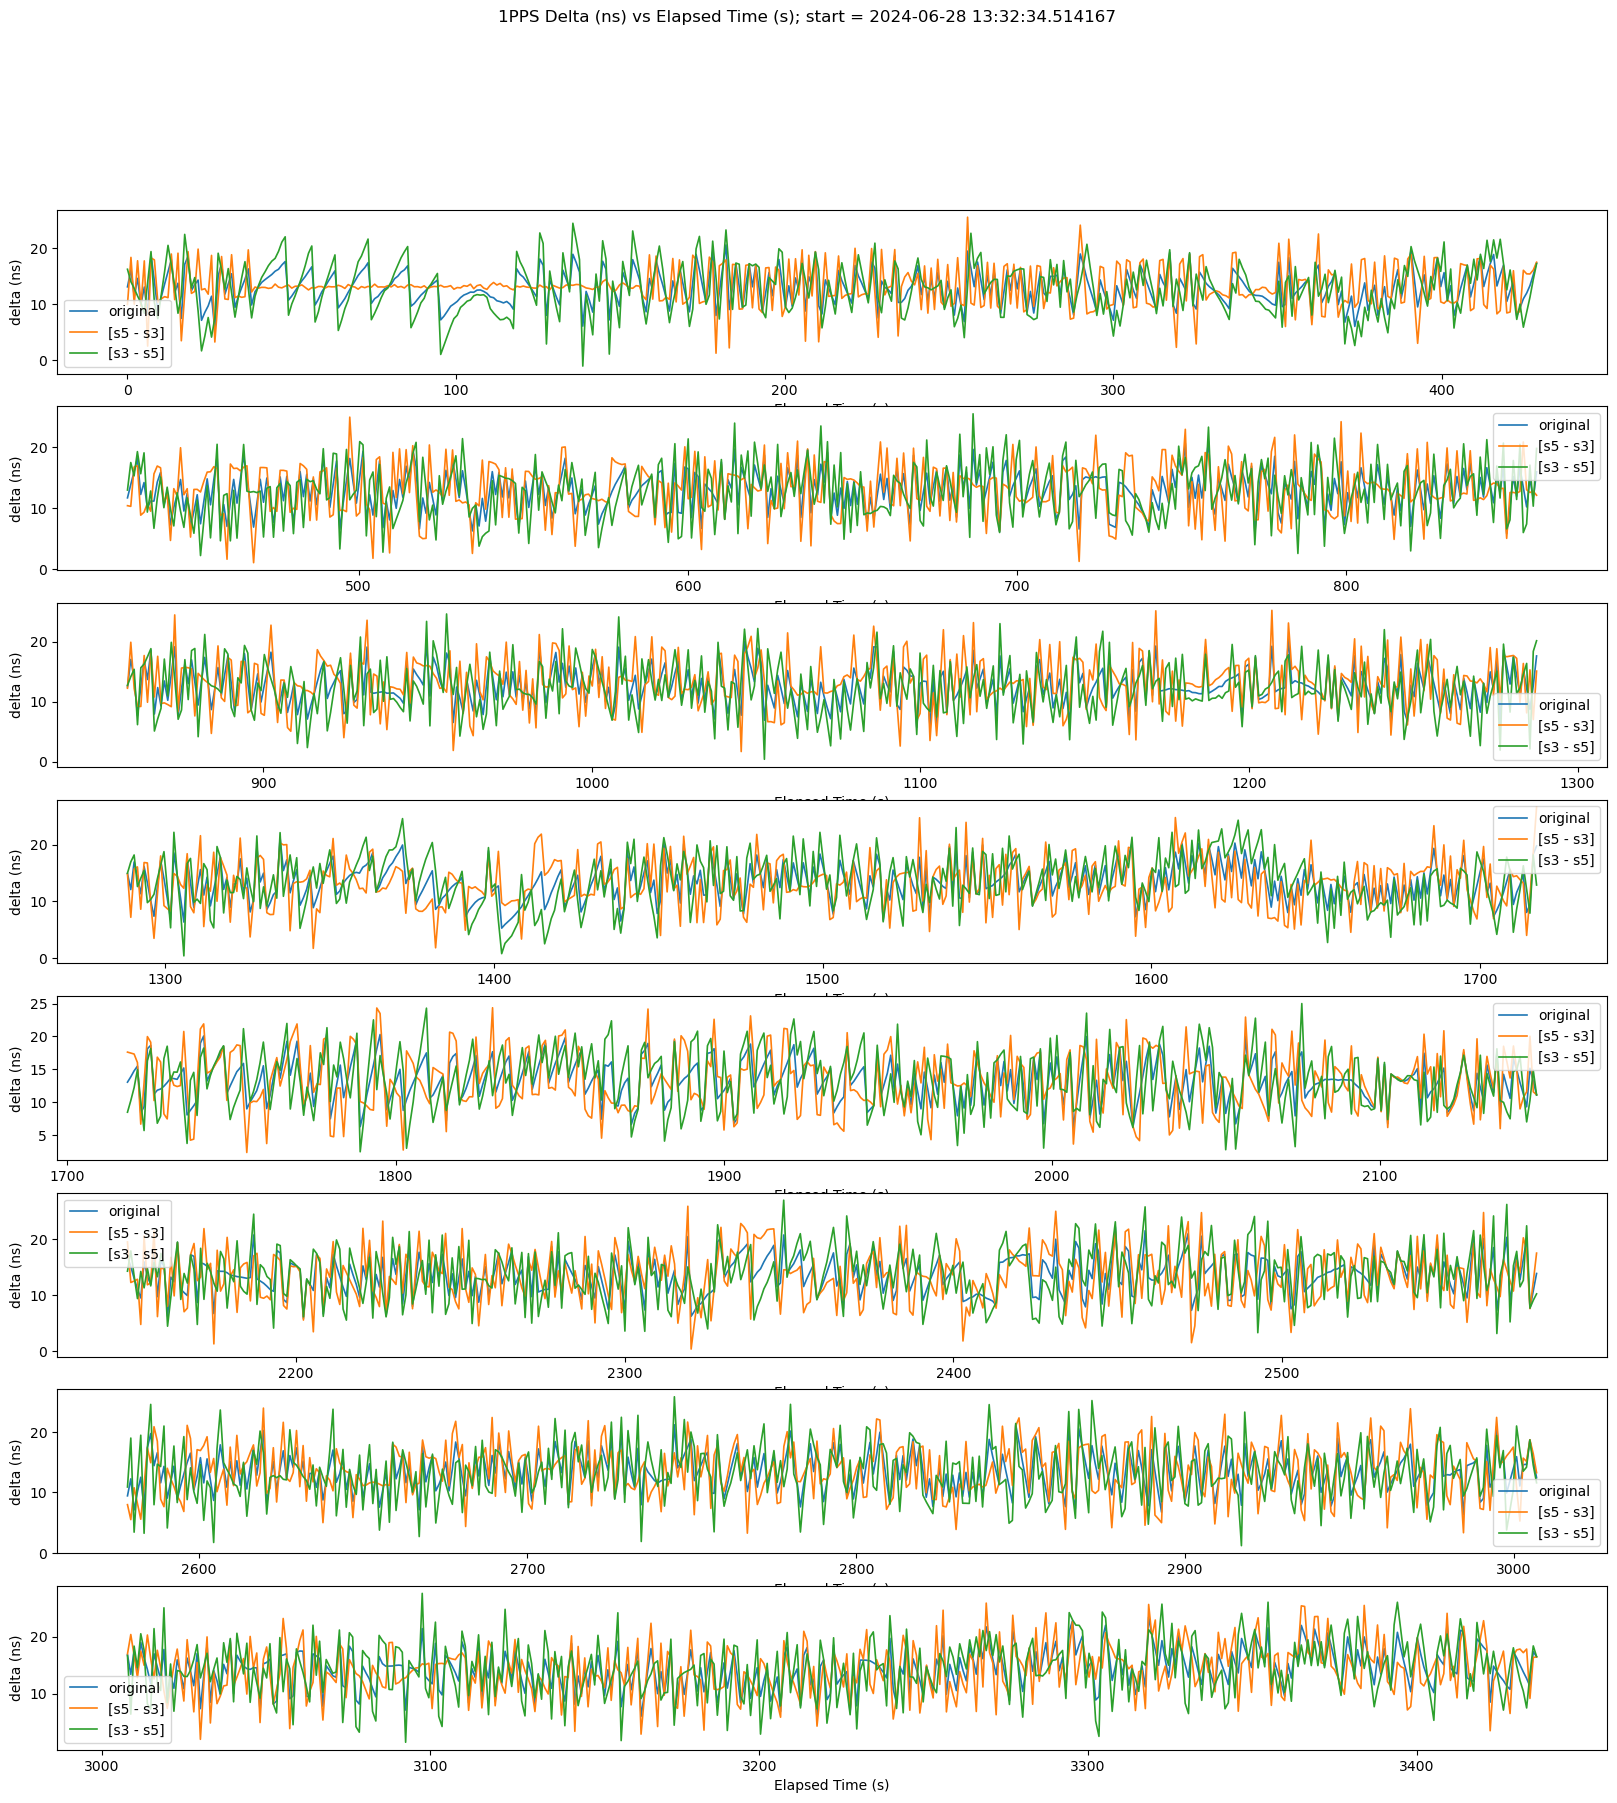

In [73]:
# Original deltas
nslices = 8
slice_size = (len(d_aligned) // nslices)
f, axs = plt.subplots(nslices, 1, figsize=(20, 20))
f.suptitle(f'1PPS Delta (ns) vs Elapsed Time (s); start = {d_aligned["unix_timestamp"][0]}');

for i in range(nslices):
    d_aligned_slice = d_aligned[slice_size * i: slice_size * (i + 1)]
    sns.lineplot(d_aligned_slice, x='Elapsed Time (s)', y='delta (ns)', linewidth=1.2, ax=axs[i], label='original')
    sns.lineplot(d_aligned_slice, x='Elapsed Time (s)', y='delta & qerrs (ns) [s5 - s3]', linewidth=1.2, ax=axs[i], label='[s5 - s3]')
    sns.lineplot(d_aligned_slice, x='Elapsed Time (s)', y='delta & qerrs (ns) [s3 - s5]', linewidth=1.2, ax=axs[i], label='[s3 - s5]')

count    3414.000000
mean       13.294710
std         3.219015
min         5.233000
25%        11.005750
50%        13.248500
75%        15.547750
max        23.431000
Name: delta (ns), dtype: float64 


count    3414.000000
mean       13.231481
std         4.638352
min        -1.117000
25%         9.961000
50%        13.282000
75%        16.543000
max        27.599000
Name: delta & qerrs (ns) [s3 - s5], dtype: float64 


count    3414.000000
mean       13.357939
std         4.350975
min         0.373000
25%        10.404500
50%        13.167500
75%        16.497000
max        26.645000
Name: delta & qerrs (ns) [s5 - s3], dtype: float64 




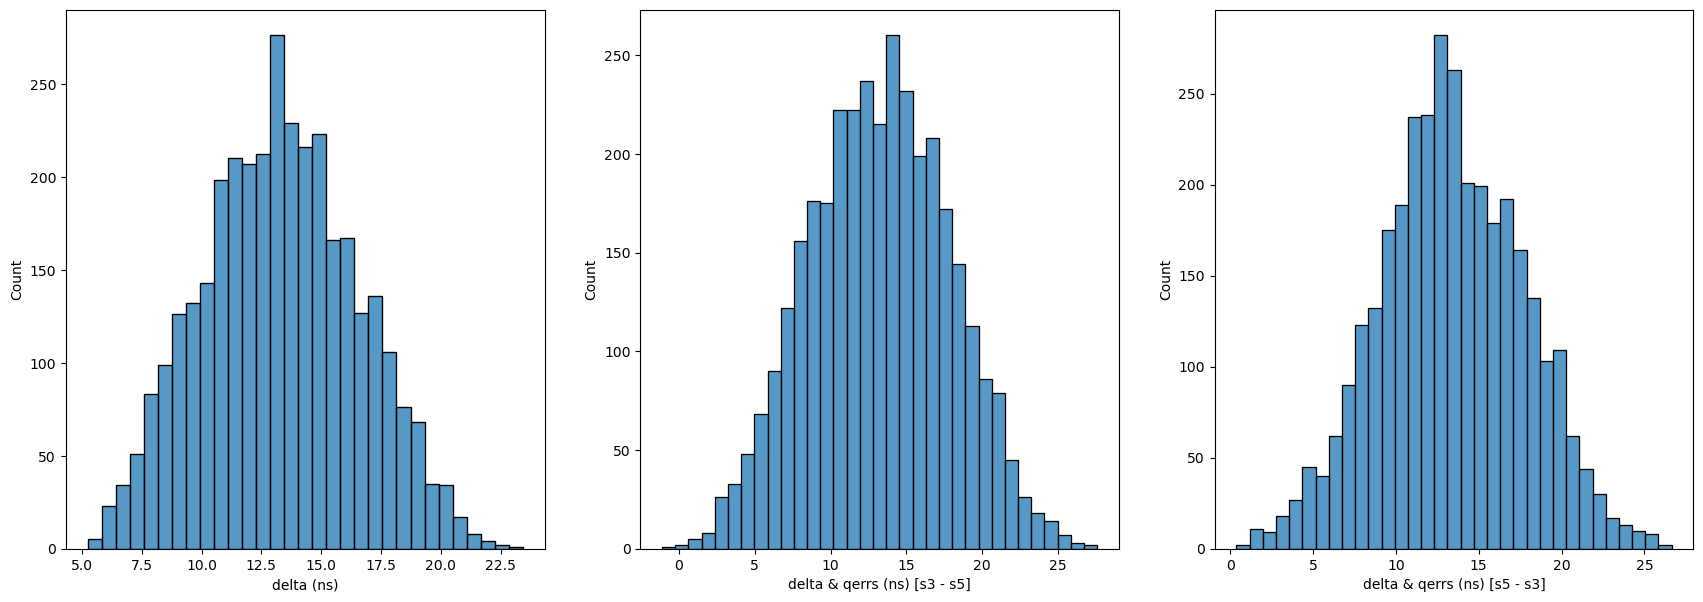

In [74]:
f, axs = plt.subplots(1, 3, figsize=(21, 7))


cols = ['delta (ns)', 'delta & qerrs (ns) [s3 - s5]', 'delta & qerrs (ns) [s5 - s3]']
for i in range(len(cols)):
    key = cols[i]
    sns.histplot(d_aligned, x=key, ax=axs[i]);
    # print(f'Summary stats for {key}\n')
    print(d_aligned[key].describe(), '\n\n')